### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

### Importing Engine

In [ ]:
from engine.data_handler import DataHandler
from engine.strategy import Strategy, SignalType
from engine.portfolio import Portfolio
from engine.events import MarketEvent, SignalEvent, OrderEvent, FillEvent
from engine.order_execution import SimulatedExecutionHandler
from engine.performance import Performance

### Create Engine

In [3]:
data_handler = DataHandler('AAPL')
strategy = Strategy(0.1, 10, 30)
portfolio = Portfolio()
order_executer = SimulatedExecutionHandler(portfolio)

### Fetch Data

In [4]:
data_handler.fetch_data()
data_handler.fetch_data()
data_handler.prepare(fast_window=10, slow_window=30)
data_handler.get_data()

,Close,SMA_10,SMA_30
Date,,,
1980-12-12 00:00:00-05:00,0.098597,NaN,NaN
1980-12-15 00:00:00-05:00,0.093453,NaN,NaN
1980-12-16 00:00:00-05:00,0.086594,NaN,NaN
1980-12-17 00:00:00-05:00,0.088737,NaN,NaN
1980-12-18 00:00:00-05:00,0.091310,NaN,NaN
...,...,...,...
2025-07-18 00:00:00-04:00,211.179993,210.375999,204.764000
2025-07-21 00:00:00-04:00,212.479996,210.628999,205.159000
2025-07-22 00:00:00-04:00,214.399994,211.067999,205.508333


### Main Loop

In [ ]:
from collections import deque

portfolio.event_queue = deque()
portfolio_history = []
data_handler.reset()

running = True
while running:
    # Add the first market event
    new_market_event = MarketEvent('AAPL')
    portfolio.event_queue.append(new_market_event)

    print("\n--- New Market Event ---")

    while len(portfolio.event_queue) > 0:
        # Pull the next event off the queue
        latest_event = portfolio.event_queue.popleft()
        print(f"Processing event: {type(latest_event).__name__}")

        if isinstance(latest_event, MarketEvent):
            try:
                bar = data_handler.get_next_bar()
                current_datetime = bar.name.tz_convert(None)
                print(f"Fetched new bar for {latest_event.symbol} at {current_datetime}")
            except ValueError:
                print("[ERROR] Data not fetched yet. Call fetch_data() first.")
                running = False
                break
            except IndexError:
                print("[INFO] No more data available.")
                running = False
                break

            try:
                portfolio.update_price(latest_event.symbol, bar)
                portfolio.update_total_value()
                print(f"Updated price and total value. Total portfolio value: {portfolio.total_value:.2f}")
            except Exception as e:
                print(f"[ERROR] Updating portfolio failed: {e}")
                running = False
                break

            try:
                verdict = strategy.verdict(bar)
                if verdict == SignalType.BUY or verdict == SignalType.SELL:
                    print(f"Strategy decision: {verdict}")
                    portfolio.event_queue.append(SignalEvent(latest_event.symbol, verdict))
                else:
                    print(f"Strategy decision: ", end="")
                    print(SignalType.HOLD)
            except Exception as e:
                print(f"[ERROR] Strategy evaluation failed: {e}")

        elif isinstance(latest_event, SignalEvent):
            try:
                order_event = portfolio.process_signal(latest_event)
                if order_event is None:
                    print(f"[WARNING] Insufficient funds for signal: {latest_event}")
                else:
                    print(f"Signal processed, generated order: {order_event}")
                    portfolio.event_queue.append(order_event)
            except Exception as e:
                print(f"[ERROR] Processing signal failed: {e}")

        elif isinstance(latest_event, OrderEvent):
            try:
                fill_event = order_executer.execute_order(latest_event)
                print(f"Order executed: {fill_event}")
                portfolio.event_queue.append(fill_event)
            except Exception as e:
                print(f"[ERROR] Order execution failed: {e}")

        elif isinstance(latest_event, FillEvent):
            try:
                portfolio.process_fill(latest_event)
                print(f"Processed fill event: {latest_event}")
            except Exception as e:
                print(f"[ERROR] Fill processing failed: {e}")

        else:
            print("[ERROR] Unknown event type encountered:")
            print(latest_event)

    try:
        snapshot = {
            "datetime": current_datetime,
            "cash": portfolio.cash,
            "holdings": portfolio.holdings.copy(),
            "total_value": portfolio.total_value,
            "positions": portfolio.positions.copy()
        }
        portfolio_history.append(snapshot)
        print(f"[INFO] Snapshot saved at {current_datetime}")
    except Exception as e:
        print(f"[ERROR] Failed to log portfolio snapshot: {e}")



--- New Market Event ---
Processing event: MarketEvent
Fetched new bar for AAPL at 1981-01-27 05:00:00
Updated price and total value. Total portfolio value: 100000.00
Strategy decision: Hold
[INFO] Snapshot saved at 1981-01-27 05:00:00

--- New Market Event ---
Processing event: MarketEvent
Fetched new bar for AAPL at 1981-01-28 05:00:00
Updated price and total value. Total portfolio value: 100000.00
Strategy decision: Hold
[INFO] Snapshot saved at 1981-01-28 05:00:00

--- New Market Event ---
Processing event: MarketEvent
Fetched new bar for AAPL at 1981-01-29 05:00:00
Updated price and total value. Total portfolio value: 100000.00
Strategy decision: Hold
[INFO] Snapshot saved at 1981-01-29 05:00:00

--- New Market Event ---
Processing event: MarketEvent
Fetched new bar for AAPL at 1981-01-30 05:00:00
Updated price and total value. Total portfolio value: 100000.00
Strategy decision: Sell
Processing event: SignalEvent
[WARNING] Insufficient funds for signal: <engine.events.SignalEvent

### Checking Performance

In [6]:
performance = Performance(portfolio_history)
performance.calculate_performance(0.05)

{'total_return': np.float64(0.008223336842732909),
 'sharpe_ratio': np.float64(-21369.29382687926),
 'max_drawdown': -0.0030374277047650056}

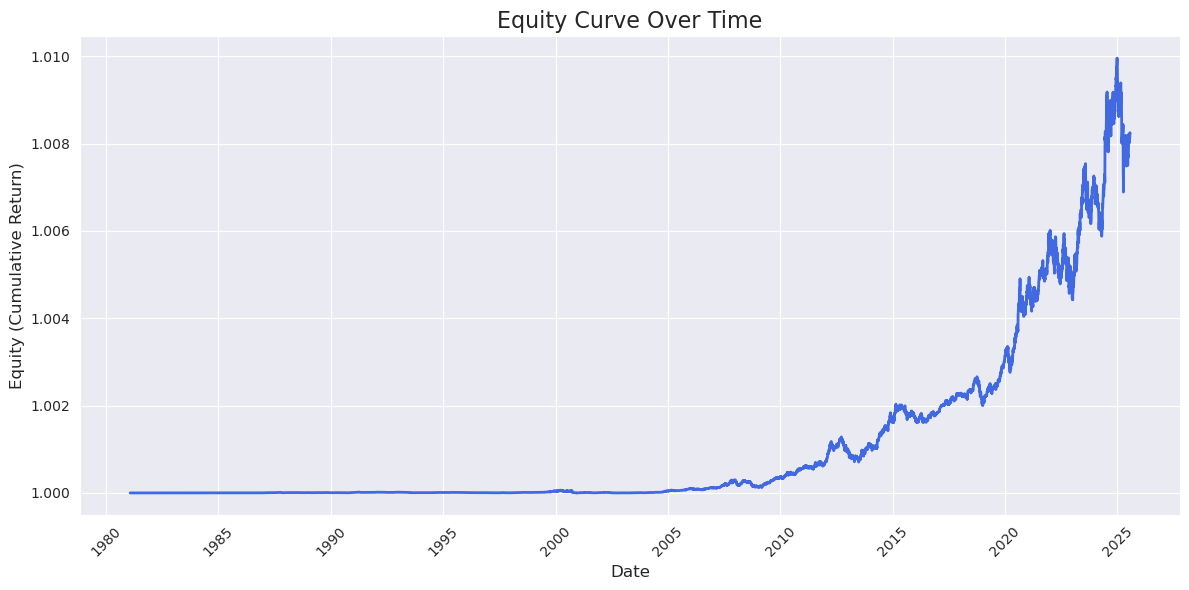

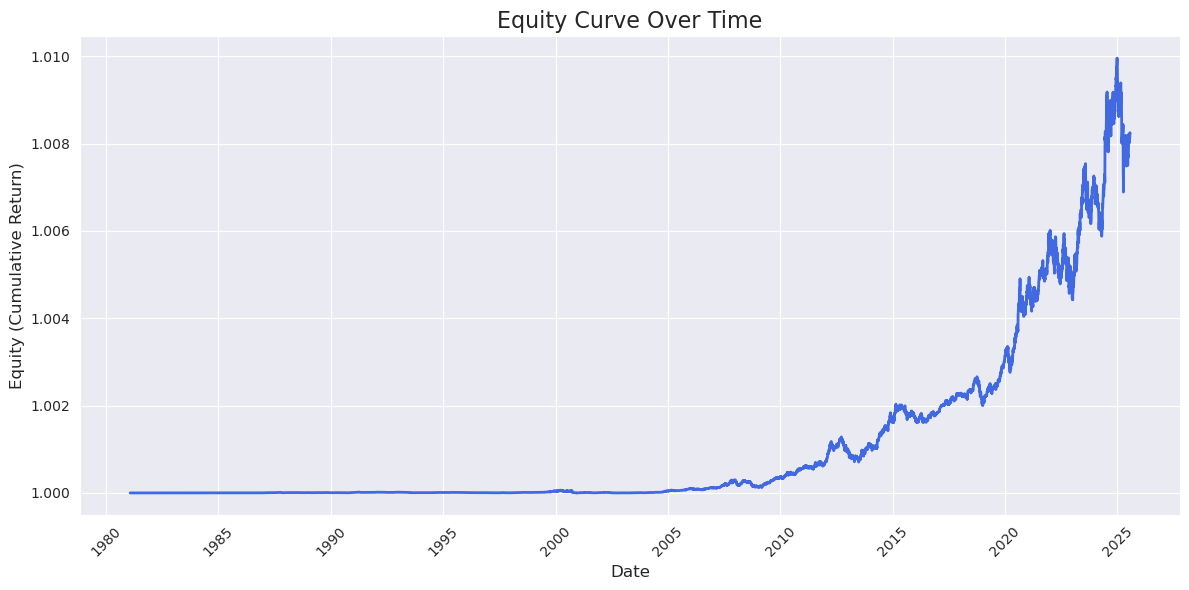

In [7]:
performance.plot_equity_curve()